https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [1]:
from DLtools.Data import instant_data,intersection,del_less_col,station_sel
from DLtools.evaluation_rec import real_eva_error,record_list_result
from DLtools.MachineLearning import test_stationarity,tsplot

import pmdarima as pm
from tqdm import tqdm
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

# Loading data

In [2]:
loading = instant_data()
df,mode = loading.hourly_instant(),'hour'
#df,mode = loading.daily_instant(),'day'

if mode =='hour': n_past,n_future = 72,72
elif mode =='day': n_past,n_future = 60,30
else: n_future=None; print('incorrect input')

st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)
#----------------------------------
save_path =host_path+'/ARIMA/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# NaN handle / Confirm Data

<AxesSubplot:xlabel='date'>

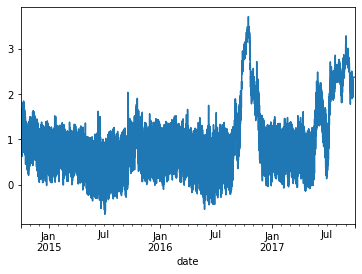

In [3]:
split_date = '2016-11-01'
data = df[start_p:stop_p]
data = data.interpolate(limit=3000000000,limit_direction='both').astype('float32')
#data['Day'] = data.index.dayofyear #add day


data_uni=data[target]
data_uni.plot()

<AxesSubplot:xlabel='date'>

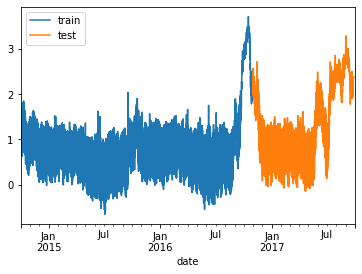

In [4]:
#cut = int(len(data_uni)*.7)
#train,test = data_uni.iloc[:cut],data_uni.iloc[cut-1:]

train,test = data_uni[:split_date],data_uni[split_date:]
train.plot(label='train',legend=True)
test.plot(label='test',legend=True)

In [5]:
 data_uni.iloc[cut-1:cut]

NameError: name 'cut' is not defined

# Stationary Test

Test Statistic             -2.445071
p-value                     0.129417
Lags                       49.000000
Observations            26278.000000
Critical Value (1%)        -3.430599
Critical Value (5%)        -2.861650
Critical Value (10%)       -2.566829
dtype: float64
weak evidence against null hypothesis, time series has a  unit root, indicating it is non-stationary


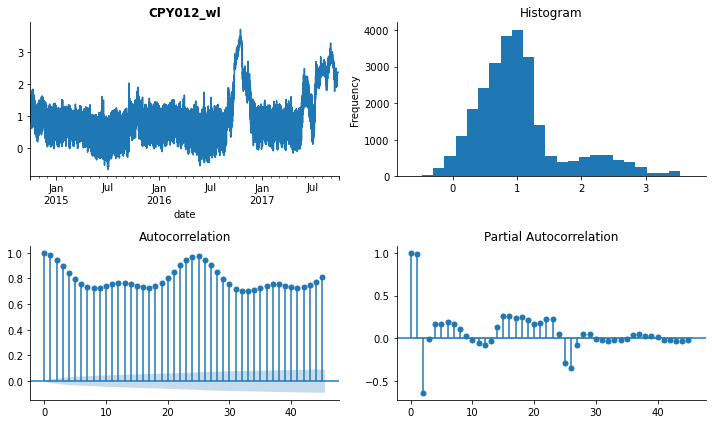

In [12]:
# Define target
tsplot(data_uni,target)
test_stationarity(data_uni)

In [1]:
from cuml.tsa.auto_arima import AutoARIMA

ModuleNotFoundError: No module named 'cuml'

# Auto ARIMA

In [6]:
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest

In [7]:
# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(data_uni)  # (0.01, False)
print("p value:{}, diff :{}".format(p_val,should_diff))

p value:0.08105063851727153, diff :True


In [13]:
stepwise_fit = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-32027.177, Time=4.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22248.857, Time=1.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31991.488, Time=0.99 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-29101.067, Time=2.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22250.856, Time=0.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-31987.591, Time=6.97 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-32380.415, Time=8.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-31568.770, Time=4.83 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-36198.195, Time=16.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=23.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-35844.454, Time=20.46 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-32859.337, Time=14.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-36189.580, Time=17.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-36176.572, Time=23.85 sec
 ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                18312
Model:               SARIMAX(2, 1, 4)   Log Likelihood               18760.525
Date:                Fri, 25 Dec 2020   AIC                         -37507.051
Time:                        16:13:20   BIC                         -37452.344
Sample:                             0   HQIC                        -37489.075
                              - 18312                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7337      0.001   1611.775      0.000       1.732       1.736
ar.L2         -0.9891      0.001   -891.869      0.000      -0.991      -0.987
ma.L1         -1.3083      0.005   -285.908      0.000      -1.317      -1.299
ma.L2          0.5031      0.008     65.911      0.000       0.488       0.518
ma.L3          0.1356      0.010     13.008      0.000       0.115       0.156
ma.L4          0.1149      0.007     16.471      0.000       0.101       0.129
sigma2         0.0075   4.45e-05    169.423      0.000       0.007       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):            100645.72
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

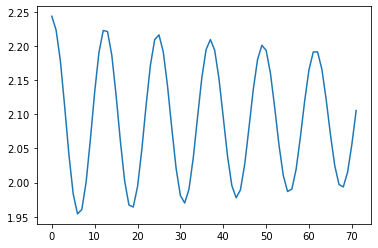

In [15]:
result=stepwise_fit.predict(n_periods=72)
plt.plot(result)

In [99]:
idx=test.index

In [112]:
a = pd.Series([1,2,3,4],index=idx[:4],name='yhat')
b = pd.Series([5,6,7,8],index=idx[:4],name='y')
pd.concat([a,b],axis=1)

,yhat,y
date,,
2016-11-01 00:00:00,1,5
2016-11-01 01:00:00,2,6
2016-11-01 02:00:00,3,7
2016-11-01 03:00:00,4,8


In [ ]:
history = [x for x in train]
predict=list()
idx=test.index

for t in tqdm(range(len(test))):
    stepwise_fit.update(history)
    yhat = stepwise_fit.predict(n_periods=72)
    predict.append(yhat)
    #testPredict = pd.concat([testPredict,pd.Series(yhat,index=idx[t:t+72])],axis=1)
    #Ytest=pd.concat([Ytest,pd.Series(save,index=idx[t:t+72])])
    obs = test[t]
    history.append(obs)
    history.pop(0)

In [197]:
yhat = np.array(predict)
#y = np.array(savetest)

In [207]:
hour = ['h{}'.format(i+1) for i in range(72)]
hour

['h1',
 'h2',
 'h3',
 'h4',
 'h5',
 'h6',
 'h7',
 'h8',
 'h9',
 'h10',
 'h11',
 'h12',
 'h13',
 'h14',
 'h15',
 'h16',
 'h17',
 'h18',
 'h19',
 'h20',
 'h21',
 'h22',
 'h23',
 'h24',
 'h25',
 'h26',
 'h27',
 'h28',
 'h29',
 'h30',
 'h31',
 'h32',
 'h33',
 'h34',
 'h35',
 'h36',
 'h37',
 'h38',
 'h39',
 'h40',
 'h41',
 'h42',
 'h43',
 'h44',
 'h45',
 'h46',
 'h47',
 'h48',
 'h49',
 'h50',
 'h51',
 'h52',
 'h53',
 'h54',
 'h55',
 'h56',
 'h57',
 'h58',
 'h59',
 'h60',
 'h61',
 'h62',
 'h63',
 'h64',
 'h65',
 'h66',
 'h67',
 'h68',
 'h69',
 'h70',
 'h71',
 'h72']

In [201]:
hour = ['h'.format((i+1) for i in range( 72))]
df_test = pd.DataFrame(yhat,columns= hour)
df_test

ValueError: Shape of passed values is (32, 72), indices imply (32, 1)

In [182]:
pd.Series((df_test.iloc[:,1].values),index=idx[1:1+20])

date
2016-11-01 01:00:00    2.223522
2016-11-01 02:00:00    2.161450
2016-11-01 03:00:00    2.069823
2016-11-01 04:00:00    2.009611
2016-11-01 05:00:00    1.987035
2016-11-01 06:00:00    1.986322
2016-11-01 07:00:00    2.013211
2016-11-01 08:00:00    2.040397
2016-11-01 09:00:00    2.108893
2016-11-01 10:00:00    2.263761
2016-11-01 11:00:00    2.429691
2016-11-01 12:00:00    2.261810
2016-11-01 13:00:00    2.781440
2016-11-01 14:00:00    2.160519
2016-11-01 15:00:00    2.176818
2016-11-01 16:00:00    2.169750
2016-11-01 17:00:00    2.136433
2016-11-01 18:00:00    2.137291
2016-11-01 19:00:00    2.175448
2016-11-01 20:00:00    2.253585
Freq: H, dtype: float64

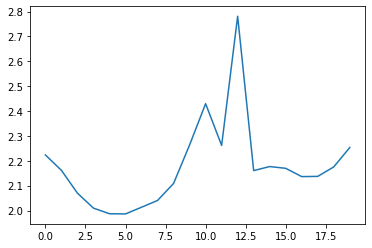

In [190]:
plt.plot(yhat.T[1])

In [185]:
dummy=pd.DataFrame()
for i in range(72):
    x = pd.Series((df_test.iloc[:,i].values),index=idx[i:i+20])
    dummy = pd.concat([dummy,x],axis=1)
dummy.T

,2016-11-01 00:00:00,2016-11-01 01:00:00,2016-11-01 02:00:00,2016-11-01 03:00:00,2016-11-01 04:00:00,2016-11-01 05:00:00,2016-11-01 06:00:00,2016-11-01 07:00:00,2016-11-01 08:00:00,2016-11-01 09:00:00,...,2016-11-04 09:00:00,2016-11-04 10:00:00,2016-11-04 11:00:00,2016-11-04 12:00:00,2016-11-04 13:00:00,2016-11-04 14:00:00,2016-11-04 15:00:00,2016-11-04 16:00:00,2016-11-04 17:00:00,2016-11-04 18:00:00
0,2.24353,2.208995,2.141512,2.081916,2.040123,2.008230,1.998342,1.996578,2.042898,2.181696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,2.223522,2.161450,2.069823,2.009611,1.987035,1.986322,2.013211,2.040397,2.108893,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,2.178539,2.093277,1.995386,1.951144,1.961390,1.999072,2.059963,2.105951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,2.111901,2.020947,1.935640,1.922275,1.971901,2.044554,2.127274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,2.040869,1.962983,1.905691,1.930059,2.015489,2.110791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.018940,2.164247,2.267956,2.366659,2.438067,2.478522,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.898099,2.066456,2.222705,2.322286,2.402035,2.444996,2.454826,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.572687,1.950702,2.129036,2.278942,2.359530,2.410482,2.422713,2.407541,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.020711,2.587465,2.019769,2.190527,2.318617,2.370357,2.390135,2.377230,2.349005,NaN


In [149]:
yhat[:,0]

array([2.24353042, 2.20899506, 2.1415117 ])

# cross validation

In [48]:
from pmdarima import model_selection

cv = model_selection.SlidingWindowForecastCV(window_size=72, step=72, h=1)
model1_cv_scores = model_selection.cross_val_score(    stepwise_fit, train, scoring='mean_squared_error', cv=cv, verbose=2)

print("Model 1 CV scores: {}".format(model1_cv_scores.tolist()))

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

[CV] fold=117 ........................................................
[CV] fold=118 ........................................................
[CV] fold=119 ........................................................
[CV] fold=120 ........................................................
[CV] fold=121 ........................................................
[CV] fold=122 ........................................................
[CV] fold=123 ........................................................
[CV] fold=124 ........................................................
[CV] fold=125 ........................................................
[CV] fold=126 ........................................................
[CV] fold=127 ........................................................
[CV] fold=128 ........................................................
[CV] fold=129 ........................................................
[CV] fold=130 ........................................................
[CV] f

[CV] fold=233 ........................................................
[CV] fold=234 ........................................................
[CV] fold=235 ........................................................
[CV] fold=236 ........................................................
[CV] fold=237 ........................................................
[CV] fold=238 ........................................................
[CV] fold=239 ........................................................
[CV] fold=240 ........................................................
[CV] fold=241 ........................................................
[CV] fold=242 ........................................................
[CV] fold=243 ........................................................
[CV] fold=244 ........................................................
[CV] fold=245 ........................................................
[CV] fold=246 ........................................................
[CV] f

In [52]:
# Pick based on which has a lower mean error rate
m1_average_error = np.average(model1_cv_scores)
errors = [m1_average_error]
models = [stepwise_fit]

# print out the answer
better_index = np.argmin(errors)  # type: int
print("Lowest average mse: {} (model{})".format(
    errors[better_index], better_index + 1))
print("Best model: {}".format(models[better_index]))

Lowest average mse: 0.006591557847273985 (model1)
Best model:  ARIMA(2,1,4)(0,0,0)[0]          


In [53]:
better_index = np.argmin(errors)  # type: int
print("Lowest average SMAPE: {} (model{})".format(
    errors[better_index], better_index + 1))
print("Best model: {}".format(models[better_index]))

Lowest average SMAPE: 0.006591557847273985 (model1)
Best model:  ARIMA(2,1,4)(0,0,0)[0]          


In [54]:
from sklearn.model_selection import KFold

# Get prediction for 14days/ 72 hours

In [23]:
pdq=(1,1,0)
model = ARIMA(train, order=pdq)
model_fit = model.fit(disp=0)

start_idx=len(train)
end_idx=len(train)+n_future
predictTest=model_fit.predict(start=start_idx,end=end_idx,typ='levels')

<AxesSubplot:title={'center':'mse0.030 | nse-3.067 | r20.124'}, xlabel='date'>

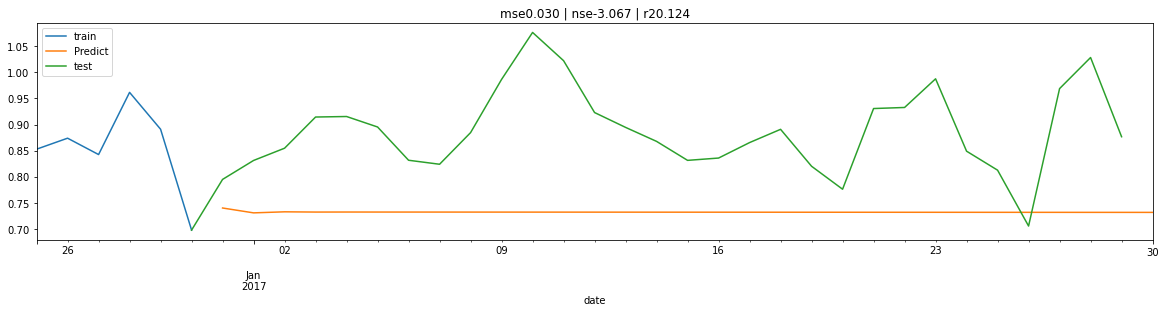

In [24]:
mse,nse,r2=real_eva_error(test[:len(predictTest)],predictTest)
plt.figure(figsize=(20,4))
plt.title("mse{:.3f} | nse{:.3f} | r2{:.3f}".format(mse,nse,r2))
train['2016-12-25':].plot(label='train',legend=True)
predictTest.plot(label='Predict',legend=True)
test[:len(predictTest)].plot(label='test',legend=True)


# ARIMA rolling in time(Code from machinery.com)

In [25]:
history = [x for x in train]
#1 predictions = pd.DataFrame()
predictions=list()
mse_l,nse_l,r2_l = list(),list(),list()
#Set pdq
pdq=(1,1,0)
for t in tqdm(range(len(test))):
    #1 history=pd.Series(history,index=data[:len(history)].index)
    model = ARIMA(history, order=pdq)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast(steps=n_future)[0]
    predictions.append(yhat)   
    obs = test[t]
    history.append(obs)  

# df_out = pd.DataFrame(np.array(predictions),columns=['day'+str(i) for i in range(1,15)],index=test.index)


100%|██████████| 457/457 [00:12<00:00, 35.36it/s]


In [36]:
predictions=np.array(predictions)
for i in range(n_future):
    mse,nse,r2 = real_eva_error(test,predictions[i,:])
    plt.plot(test)
    plt.plot(yhat)
    plt.title('{}Water Level {} Forecast vs Actuals\n'.format(i,target)+' MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2))
    plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [456, 30]

In [37]:
history = [x for x in train]
predictions = pd.DataFrame()

#Set pdq
pdq=(1,1,0)

for t in tqdm(range(len(test))):
    history=pd.Series(history,index=data[:len(history)].index)
    model = ARIMA(history, order=pdq)
    model_fit = model.fit(disp=0)

    start_idx=len(history)
    end_idx=len(history)+n_future
    yhat = model_fit.predict(start=start_idx,end=end_idx,typ='levels')
    predictions=pd.concat([predictions,yhat],axis=1)

    obs = test[t]
    history=list(history)
    history.append(obs)  



 32%|███▏      | 144/456 [00:03<00:08, 35.93it/s]/home/song/anaconda3/envs/tf/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
100%|██████████| 456/456 [00:13<00:00, 34.73it/s]


In [38]:
predictions

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-12-31,0.740253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,0.730934,0.773647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.732947,0.778368,0.823365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,0.732474,0.777348,0.825174,0.849672,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.732546,0.777593,0.824850,0.850885,0.901466,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.97986,0.959392,0.950068,0.905159,0.808732
2018-04-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.959517,0.950187,0.905249,0.808760
2018-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.950307,0.905340,0.808788
2018-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.905430,0.808816
